In [91]:
import hes1_langevin_Antoine as langevin
import hes1_master_Antoine as master
import hes1_utils_Antoine as utils
import hes1_utils_general as general
# import jochen_utils as jutils

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy.interpolate as spinter
import scipy.fft
import time
import datetime as dt
import os
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import wasserstein_distance
from numba import jit
from scipy.special import rel_entr


import warnings
warnings.filterwarnings("ignore")

In [92]:
ratio=(1+np.sqrt(5))/2

In [93]:
date_and_time=time.localtime()
string_date=str(date_and_time.tm_year)+'-'+str(date_and_time.tm_mon)+'-'+str(date_and_time.tm_mday)+'-'+str(date_and_time.tm_hour)+'-'+str(date_and_time.tm_min)+'-'+str(date_and_time.tm_sec)

Specify hereafter the folder you want to use

In [94]:
read_directory = os.path.join(os.getcwd(),'paper_plots' + string_date + ' timeseries')
read_directory = os.path.join(os.getcwd(),'paper_plots_timeseries')

In [95]:
try:
    os.makedirs(os.path.join(read_directory,'data'))
    os.makedirs(os.path.join(read_directory,'plots'))
except FileExistsError:
    pass

In [96]:
# font = {
    # 'family' : 'Arial',
    # 'color'  : 'black',
    # 'weight' : 'normal',
    # 'size'   : 36,
# }

font = {'size'   : 8,
        'sans-serif' : 'Arial'}
plt.rc('font', **font)

# legendFont = 20

# Influence of the swtiching noise on the full model

We plot timeseries of the full model (standard Gillespie algorithm) and of the full model using average switching noise (Gillespie algorithm where the environment switching is replaced by the Hill function).
Functions are defined in the file "master".

We use the set of parameters proposed in _Quantitative single-cell live imaging links HES5 dynamics with cell-state and fate in murine neurogenesis_ (Cerys S. Manning, Veronica Biga, James Boyd, Jochen Kursawe, Bodvar Ymisson, David G. Spiller, Christopher M. Sanderson, Tobias Galla, Magnus Rattray, Nancy Papalopulu), figure 6.

In [97]:
alpha_m=39.93
alpha_p=21.56
mu_m=np.log(2)/30
mu_p=np.log(2)/90
h=4.78
P_0=24201.01

T=10000
delta_t=0.0001
# delta_t=0.01

n_t=int(T/delta_t)

# val_lambda=10.0
# val_Omega=100.0
# val_tau=33.0

val_lambda=0.1
val_Omega=1
val_tau=33.0
# todo: use val_lambda=0.1 and val_Omega = 1 

In [98]:
time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,mu_p=mu_p,h=h,P_0=P_0,
                                                      lambda_s=val_lambda,        
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)

time_trajmns,mRNA_trajmns,Hes1_trajmns = master.one_trajectory_noSwitchNoise(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)

time_trajmdet,mRNA_trajmdet,Hes1_trajmdet = langevin.resolve_ODE(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,mu_p=mu_p,h=h,
                                                      P_0=P_0,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=0.01)


In [99]:
time_trajmnd,mRNA_trajmnd,Hes1_trajmnd = langevin.one_trajectory_PDMP(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,mu_p=mu_p,h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,        
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T, delta_t=delta_t)

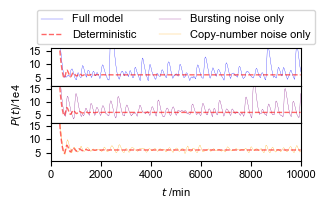

In [100]:
# fig,ax=plt.subplots(3,1, figsize=(7*ratio,7))
# fig, ax = plt.subplots(3,1, figsize=(3.15,5.25), constrained_layout = True) 
# fig, ax = plt.subplots(3,1, figsize=(3.15,1.75), constrained_layout = True, sharex = True) 
# fig, ax = plt.subplots(3,1, figsize=(3.15,2.0), sharex = True) 
fig, ax = plt.subplots(3,1, figsize=(3.3,2.0), sharex = True) 
# fig, ax = plt.subplots(3,1, figsize=(4.25,2.5), sharex = True) 
    
# ax[0].set_title('Hes1 concentration over time',fontdict=font) 

# ax[0].set_ylim(50000,70000)
ax[0].set_ylim(20000,160000)
# ax[0].set_yticks([55000, 60000, 65000])
# ax[0].set_yticklabels(['5.5', '6.0', '6.5'])  # Set y-axis tick labels manually
ax[0].set_yticks([50000, 100000, 150000])
ax[0].set_yticklabels(['5', '10', '15'])  # Set y-axis tick labels manually
ax[0].set_xlim(0,10000)
# ax[0].set_xticks([])
ax[0].tick_params(axis='x', bottom=False)  # Remove x-axis ticks for the upper plot

    
linem, = ax[0].plot(time_trajm,Hes1_trajm, color = 'blue', label = 'Full model', lw = 0.2)
# linedet, = ax[0].plot(time_trajmdet,Hes1_trajmdet,'--', color = 'red', alpha=0.3, label = 'Deterministic', lw = 0.2)
linedet, = ax[0].plot(time_trajmdet,Hes1_trajmdet,'--', color = 'red', alpha = 0.6, label = 'Deterministic', lw = 1.0)
# ax[0].legend([linem,linedet], ['Gillespie','Deterministic'],loc='lower right')



ax[1].set_ylabel('$P(t)$/1e4')
# ax[1].set_ylim(50000,70000)
ax[1].set_ylim(20000,160000)
# ax[1].set_yticks([55000, 60000, 65000])
ax[1].set_yticks([50000, 100000, 150000])
ax[1].set_yticklabels(['5', '10', '15'])  # Set y-axis tick labels manually
# ax[1].set_yticklabels(['5.5', '6.0', '6.5'])  # Set y-axis tick labels manually
ax[1].set_xlim(0,10000)
# ax[1].set_xticks([])
ax[1].tick_params(axis='x', bottom=False)  # Remove x-axis ticks for the upper plot

linemnd, = ax[1].plot(time_trajmnd,Hes1_trajmnd, color = 'purple', label = 'Bursting noise only', lw = 0.2)
linedet, = ax[1].plot(time_trajmdet,Hes1_trajmdet,'--', alpha = 0.6, color = 'red', lw = 1.0)
# ax[1].legend([linemnd,linedet], ['PDMP','Deterministic'], loc='lower right')



ax[2].set_xlabel('$t$ /min')
# ax[2].set_ylim(50000,70000)
ax[2].set_ylim(20000,160000)
# ax[2].set_yticks([55000, 60000, 65000])
# ax[2].set_yticklabels(['5.5', '6.0', '6.5'])  # Set y-axis tick labels manually
ax[2].set_yticks([50000, 100000, 150000])
ax[2].set_yticklabels(['5', '10', '15'])  # Set y-axis tick labels manually
ax[2].set_xlim(0,10000)

linemns, = ax[2].plot(time_trajmns,Hes1_trajmns, color = 'orange',label = 'Copy-number noise only', lw = 0.2)
linedet, = ax[2].plot(time_trajmdet,Hes1_trajmdet,'--', color = 'red', alpha = 0.6, lw = 1.0)
# ax[2].legend([linemns,linedet], ['Gillespie, $\lambda=\infty$','Deterministic'], loc='lower right')

handles, labels = [], []
for this_axis in ax:
    this_handle, this_label = this_axis.get_legend_handles_labels()
    handles.extend(this_handle)
    labels.extend(this_label)

plt.subplots_adjust(hspace=0)
fig.legend(handles, labels, loc='lower left', ncol =2, fontsize = 8,
           bbox_to_anchor=(0.1, 0.75))
        #    columnspacing = 1.0,  bbox_to_anchor=(0.01, 0.75))
plt.tight_layout(h_pad = 0, rect = [0,-0.05,1,0.82])
# plt.tight_layout(h_pad = 0)

plt.savefig(os.path.join(read_directory,'plots','comparison_full_with_vs_without_switching_alternative.pdf'))
    
plt.show()

# Comparison between the Langevin and the full models

We plot timeseries of the full model (standard Gillespie algorithm) and of the Langevin model i.e using SPDEs.
Functions are defined in the files "hes1_langevin_Antoine.py" and "hes1_master_Antoine.py".

In [101]:
alpha_m=39.93
alpha_p=21.56
mu_m=np.log(2)/30
mu_p=np.log(2)/90
h=4.78
P_0=24201.01

T=10000
delta_t=0.01

n_t=int(T/delta_t)

val_lambda=10
val_Omega=100
val_tau=33
# val_lambda=0.1
# val_Omega=1
# val_tau=33

In [102]:
m_stat,p_stat = utils.resolve_stationary_state(alpha_m,mu_m,alpha_p,mu_p,h,P_0)

In [103]:
time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)
        
time_trajl,mRNA_trajl,Hes1_trajl = langevin.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega)

time_trajlna,mRNA_trajlna,Hes1_trajlna = langevin.one_trajectory_LNA(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega)

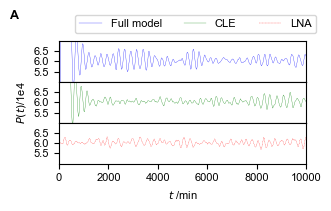

In [104]:
fig,ax=plt.subplots(3,1,figsize=(3.3,2.0), sharex = True)
    
# ax[0].set_ylim(20000,160000)
ax[0].set_xlim(0,10000)
    
linem,=ax[0].plot(time_trajm,Hes1_trajm, color = 'blue', label = 'Full model', lw = 0.2)
# ax[0].legend([linem], ['Full model'], loc='upper right')
ax[0].tick_params(axis='x', bottom=False)  # Remove x-axis ticks for the upper plot
# ax[0].set_yticks([50000, 100000, 150000])
# ax[0].set_yticklabels(['5', '10', '15'])  # Set y-axis tick labels manually
ax[0].set_ylim(50000,70000)
ax[0].set_yticks([55000, 60000, 65000])
ax[0].set_yticklabels(['5.5', '6.0', '6.5'])  # Set y-axis tick labels manually


ax[1].set_ylabel('$P(t)$/1e4') 

# ax[1].set_ylim(20000,160000)
# ax[1].set_yticks([50000, 100000, 150000])
# ax[1].set_yticklabels(['5', '10', '15'])  # Set y-axis tick labels manually
ax[1].set_ylim(50000,70000)
ax[1].set_yticks([55000, 60000, 65000])
ax[1].set_yticklabels(['5.5', '6.0', '6.5'])  # Set y-axis tick labels manually
ax[1].set_xlim(0,10000)
    
linel,=ax[1].plot(time_trajl,Hes1_trajl, color = 'green', label = 'CLE', lw = 0.2)
# ax[1].legend([linel], ['Langevin model'], loc='upper right')
ax[1].tick_params(axis='x', bottom=False)  # Remove x-axis ticks for the upper plot



ax[2].set_xlabel('$t$ /min') 

# ax[2].set_ylim(20000,160000)
# ax[2].set_xlim(0,10000)
# ax[2].set_yticks([50000, 100000, 150000])
ax[2].set_ylim(50000,70000)
ax[2].set_yticks([55000, 60000, 65000])
ax[2].set_yticklabels(['5.5', '6.0', '6.5'])  # Set y-axis tick labels manually
# ax[2].set_yticklabels(['5', '10', '15'])  # Set y-axis tick labels manually
    
linelna,=ax[2].plot(time_trajlna,Hes1_trajlna, color = 'red', label = 'LNA', lw = 0.2, ls= '--')
# ax[2].legend([linelna], ['LNA model'], loc='upper right')

handles, labels = [], []
for this_axis in ax:
    this_handle, this_label = this_axis.get_legend_handles_labels()
    handles.extend(this_handle)
    labels.extend(this_label)

plt.subplots_adjust(hspace=0)
fig.legend(handles, labels, loc='lower left', ncol =3, fontsize = 8,  bbox_to_anchor=(0.2, 0.8))
plt.tight_layout(h_pad = 0, rect = [0,-0.07,1,0.85])

fig.text(0.02,0.9,'A',size=9,weight='bold')
plt.savefig(os.path.join(read_directory,'plots','comparison_Full_vs_Langevin.pdf'))
plt.show()

In [105]:
# now simulate some trajectories and time then

import timeit

time_function1 = timeit.timeit('''master.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)''', globals=globals(), number=1)

# Measure the runtime of function2
time_function2 = timeit.timeit('''langevin.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega)''', globals=globals(), number=1)

print(f"Function1 runtime: {time_function1:.6f} seconds")
print(f"Function2 runtime: {time_function2:.6f} seconds")

# Compare the runtimes
if time_function1 < time_function2:
    print("Function1 is faster.")
else:
    print("Function2 is faster.")
    
print(time_function1/time_function2)

Function1 runtime: 61.758927 seconds
Function2 runtime: 0.085170 seconds
Function2 is faster.
725.1230036217745


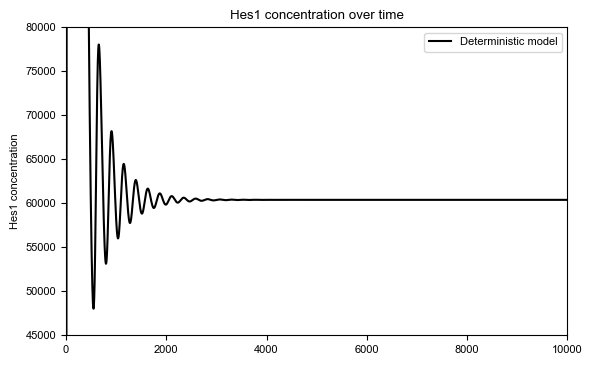

In [106]:
time_trajdet,mRNA_trajdet,Hes1_trajdet = langevin.resolve_ODE(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=delta_t)

fig,ax=plt.subplots(1,1,figsize=(4*ratio,4))
    
ax.set_title('Hes1 concentration over time') 
ax.set_ylabel('Hes1 concentration') 

ax.set_ylim(45000,80000)
ax.set_xlim(0,10000)
    
linem,=ax.plot(time_trajdet,Hes1_trajdet, color = 'black')
ax.legend([linem], ['Deterministic model'], loc='upper right')

Importantly, we observe that the deterministic solution is non oscillating. This is coherent with the results of _Wu, X. P., Eshete, M. (2011). Bifurcation analysis for a model of gene expression with delays.
Communications in Nonlinear Science and Numerical Simulation, 16(2), 1073–1088_:
if $M^*$ and $P^*$ are the constant stationary solution, then define
$$\omega_0^2 = \alpha_m \alpha_p |f'(P^*)| - \mu_m \mu_p,$$
and
$$a = \frac{-\omega_0^2 + \mu_m \mu_p}{\alpha_m \alpha_p f'(P^*)},$$
with $$ \frac{h}{P_0}\frac{(\frac{P^*}{P_0})^{h-1}}{(1+(\frac{P^*}{P_0})^h)^2}.$$

In [107]:
m_stat,p_stat = utils.resolve_stationary_state(alpha_m,mu_m,alpha_p,mu_p,h,P_0)
w_0=np.sqrt(abs(alpha_m *alpha_p*abs(h/P_0*(p_stat/P_0)**(h-1)/(1+(p_stat/P_0)**h)**2) - mu_m*mu_p))
aaa = (-w_0**2 + mu_m*mu_p)/(alpha_m *alpha_p*(-h/P_0*(p_stat/P_0)**(h-1)/(1+(p_stat/P_0)**h)**2))

Then, denote the increasing sequence $\tau_j$,
$$\tau_j = \frac{1}{\omega_0}(arccos(a)+2\pi j),$$
so that if $\tau_j \leq \tau \leq \tau_{j+1}$, there are at least $j$ oscillating (unbounded) solutions to the problem.

In [108]:
tau_0 = np.arccos(aaa)/w_0
tau_1 = (np.arccos(aaa) + 2*np.pi)/w_0

tau_0,tau_1

(37.178871215533164, 281.37866789963823)

Therefore, we do have $\tau = 33 min < \tau_0 \approx 37.2 min$. Hence, we expect no (unbounded) oscillation in the deterministic model in steady state.